In [1]:
from pathlib import Path
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import itk
import torch
import numpy as np
from sklearn.metrics import classification_report
import pydicom
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.transforms import (
    LoadImaged,
    ScaleIntensityd,
    RandCropByPosNegLabeld,
    ToTensord,
)
from monai.utils import set_determinism
import numpy as np

In [2]:

def init_data_lists(base_data_path):
    mask_paths = []
    image_paths = []
    for dir in base_data_path.iterdir():
        if dir.is_dir():
            image_paths.append(dir / f"{dir.name}_prostate.nii.gz")
            mask_paths.append(dir / f"{dir.name}_segmentation.nii.gz")
    return image_paths, mask_paths

In [3]:
base_data_path = Path(
    "/Users/iejohnson/School/spring_2024/AML/Supervised_learning/Data/SortedProstateData"
)
image_paths, mask_paths = init_data_lists(base_data_path)

# Prepare data
data_dicts = [
    {"image": img_path, "label": mask_path}
    for img_path, mask_path in zip(image_paths, mask_paths)
]

# Define transformations
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        ScaleIntensityd(keys=["image"]),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=[96, 96, 96],
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

# Create MONAI dataset and dataloader
train_ds = Dataset(data=data_dicts, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

# Create U-Net model
# model = UNet(
#     dimensions=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
#     num_res_units=2,
# )

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_image_histogram(image):
    plt.hist(image.ravel(), bins=256)
    plt.title('Image Histogram')
    plt.show()

def print_image_stats(image):
    print(f'Min: {np.min(image)}, Max: {np.max(image)}, Mean: {np.mean(image)}, Std: {np.std(image)}')

In [7]:
import itk

def load_image(image_path):
    image = itk.imread(image_path)
    image_array = itk.array_from_image(image)
    return image_array

def show_images(image_paths, mask_paths, num_images=5):
    fig, ax = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    for i in range(num_images):
        image = load_image(image_paths[i])
        mask = load_image(mask_paths[i])
        ax[i, 0].imshow(image[5], cmap='gray')
        ax[i, 0].set_title('Image')
        ax[i, 1].imshow(mask[5])
        ax[i, 1].set_title('Mask')
    plt.tight_layout()
    plt.show()

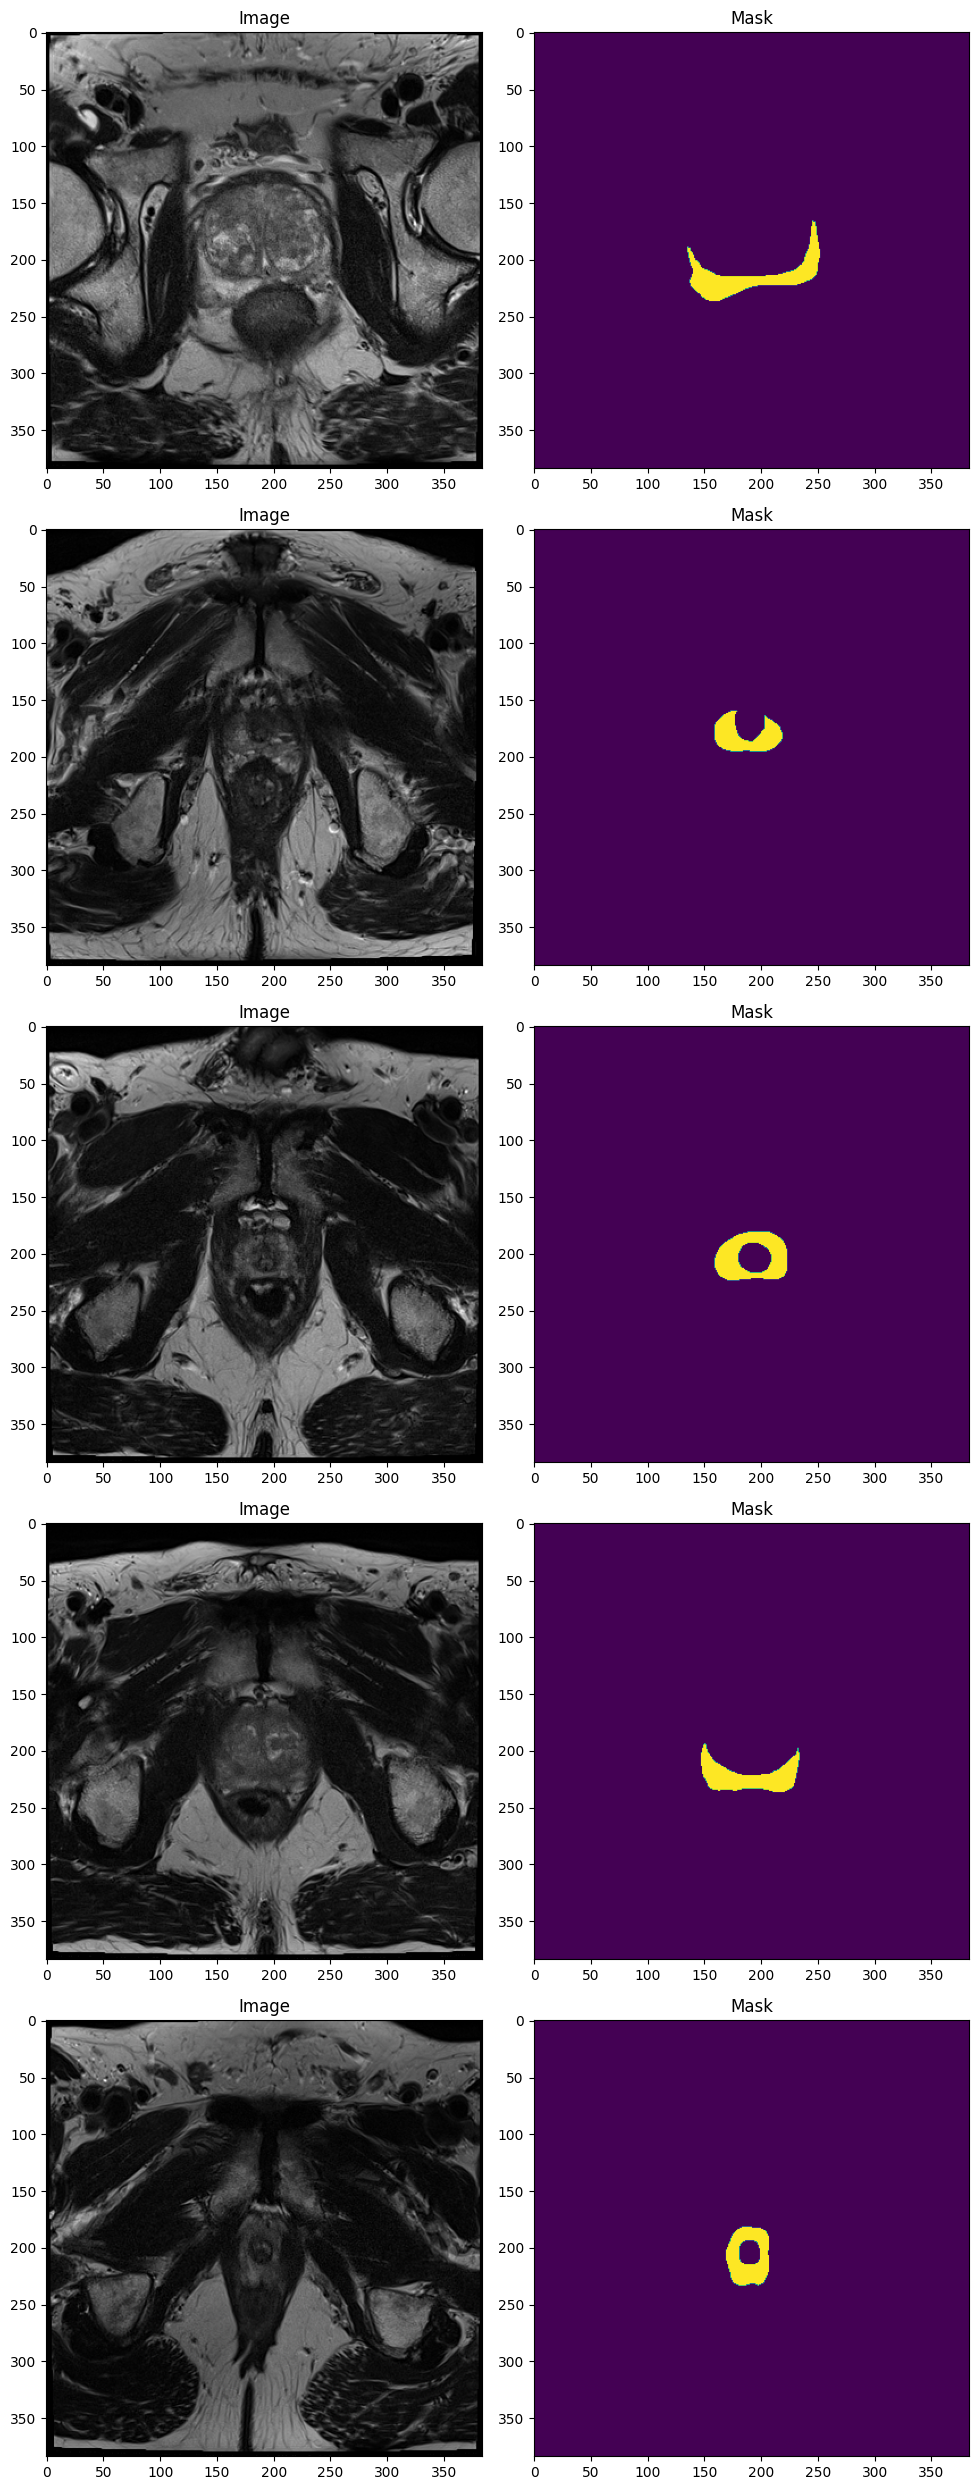

In [8]:
# Get a batch of images and masks
num_images = 5
explore_image_paths = image_paths[:num_images]
explore_mask_paths = mask_paths[:num_images]

# Show images

show_images(explore_image_paths, explore_mask_paths)

/Users/iejohnson/School/spring_2024/AML/Supervised_learning/Data/SortedProstateData/ProstateX-0060/ProstateX-0060_segmentation.nii.gz
Min: 0.0, Max: 255.0, Mean: 4.210654258728027, Std: 32.496150970458984


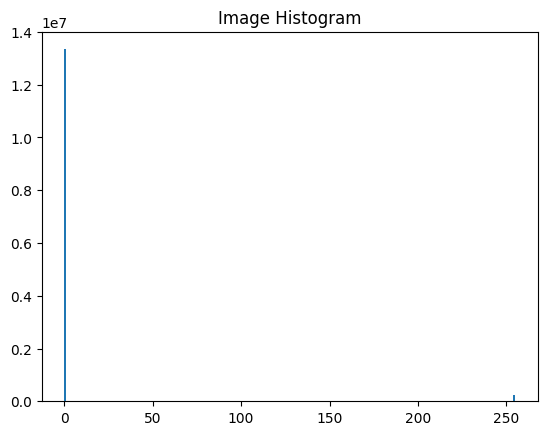

[  0. 255.]


In [11]:
print(explore_mask_paths[0])
explore_mask = load_image(explore_mask_paths[0])
print_image_stats(explore_mask)
plot_image_histogram(explore_mask)
print(np.unique(explore_mask)) # TODO Find out why there are only two values it should be multiclass